# Introduction
## Goal:
We want to increase the conversion rate, so our users perform a desired action which could be a complete payment.
<br>
<br>
current conversion rate is about 13% on average throughout the year, and that the team would be happy with an increase of 2%, meaning that the new design will be considered a success if it raises the conversion rate to 15%.

## Action:
Try two landing pages and test which is better for increasing the conversion rate.
## Hypothesis:
Changing page from old to new will increase conversion rate.
## Metric:
conversion rate.
## Data 
we will use data from [kaggle](https://www.kaggle.com/datasets/zhangluyuan/ab-testing?select=ab_data.csv)
<br>
<br>

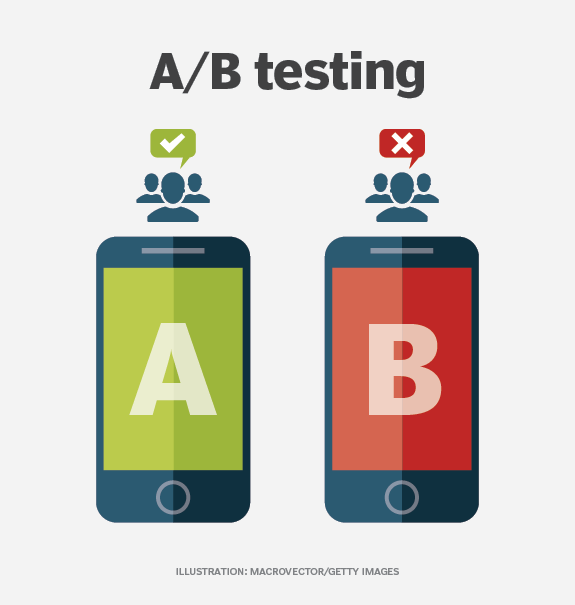

*Note: This is a One-Way Hypothesis Test which means if we rejected the new page, we would go to the old one.*  

In [16]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import sem
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

In [6]:
ab_df = pd.read_csv('ab_data.csv', parse_dates=['timestamp'])

In [7]:
ab_df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [8]:
ab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


In [9]:
ab_df['converted'].unique()

array([0, 1])

0 - The user did not buy the product during this user session
<br>
1 - The user bought the product during this user session

In [10]:
ab_df['landing_page'].unique()

array(['old_page', 'new_page'], dtype=object)

In [11]:
ab_df['group'].unique()

array(['control', 'treatment'], dtype=object)

**Treatment group** --> A group of subjects exposed to a specific treatment which is in our case is the new page
<br>
**Control group** --> A group of subjects exposed to no (or standard) which is in our case is the old page

In [38]:
pd.crosstab(ab_df['group'], ab_df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


<AxesSubplot:>

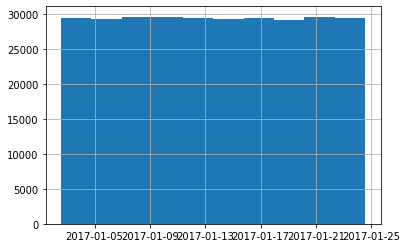

In [15]:
ab_df['timestamp'].hist()

In [39]:
ab_df.shape

(294478, 5)

In [41]:
len(ab_df['user_id'].unique())

290584

In [42]:
294478 - 290584

3894

Since the number is pretty low, we’ll go ahead and remove them from the DataFrame to avoid sampling the same users twice.

In [44]:
ab_df = ab_df.drop_duplicates(subset='user_id',keep='first')

In [13]:
(ab_df[ab_df['converted']==1].shape[0] * 100) / ab_df.shape[0]

11.965919355605513

# We should test on who exactly? all? some? how?
## Who
the larger the sample size, the more precise our estimates, the higher the chance to detect a difference in the two groups, if present.
On the other hand, the larger our sample gets, the more expensive (and impractical) our study becomes.
## How
**A power analysis** is the calculation used to estimate the smallest sample size needed for an experiment, given a required significance level, statistical power, and effect size. It helps to determine if a result from an experiment or survey is due to chance, or if it is genuine and significant.
<br>
*Power of the test (1 — β)*
<br>
*Alpha value (α)* — The critical value
<br>
*Effect size* — How big of a difference we expect there to be between the conversion rates

In [26]:
effect_size = sms.proportion_effectsize(0.13, 0.15)

In [74]:
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )
required_n = ceil(required_n)

**How did we choose those values?**
<br>
alpha=0.05 
p-value is a measure of the probability that an observed difference could have occurred just by random chance. 
<br>
power=0.8 Having set the power parameter to 0.8 in practice means that if there exists an actual difference in conversion rate between our designs, assuming the difference is the one we estimated (13% vs. 15%), we have about 80% chance to detect it as statistically significant in our test with the sample size we calculated.

In [75]:
required_n

4720

We’d need at least 4720 observations for each group.

In [45]:
control_sample = ab_df[ab_df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = ab_df[ab_df['group'] == 'treatment'].sample(n=required_n, random_state=22)

In [46]:
ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [47]:
ab_test

,user_id,timestamp,group,landing_page,converted
0,932413,2017-01-05 02:29:35.769705,control,old_page,0
1,660163,2017-01-23 12:28:57.530784,control,old_page,0
2,923145,2017-01-04 08:34:14.986015,control,old_page,0
3,798423,2017-01-05 17:15:58.968362,control,old_page,0
4,640448,2017-01-16 11:00:46.360932,control,old_page,0
...,...,...,...,...,...
9435,879385,2017-01-19 06:30:04.289006,treatment,new_page,0
9436,633855,2017-01-08 18:17:20.403731,treatment,new_page,0
9437,741596,2017-01-23 17:28:42.862009,treatment,new_page,0
9438,903058,2017-01-19 16:32:05.603197,treatment,new_page,0


In [71]:
9440 * 100 / ab_df.shape[0]

3.248630344409878

In [49]:
ab_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

In [48]:
pd.crosstab(ab_test['group'], ab_test['landing_page'])

landing_page,new_page,old_page
group,,
control,30,4690
treatment,4683,37


## experiment statstics

In [57]:
control_conv_rate = ab_test[(ab_test['group'] == 'control') & (ab_test['converted'] == 1)].shape[0] * 100 / ab_test[ab_test['group'] == 'control'].shape[0]

In [ ]:
treat_conv_rate = ab_test[(ab_test['group'] == 'treatment') & (ab_test['converted'] == 1)].shape[0] * 100 / ab_test[ab_test['group'] == 'treatment'].shape[0]

In [65]:
print(control_conv_rate)
print(treat_conv_rate)

11.673728813559322
13.177966101694915


In [61]:
ab_test.groupby('group')['converted'].std()

group
control      0.321141
treatment    0.338287
Name: converted, dtype: float64

In [64]:
# Calculate the standard error of the mean (or standard error of measurement) 
ab_test.groupby('group')['converted'].sem()

group
control      0.004674
treatment    0.004924
Name: converted, dtype: float64

Text(0.5, 1.0, 'Conversion rate by group')

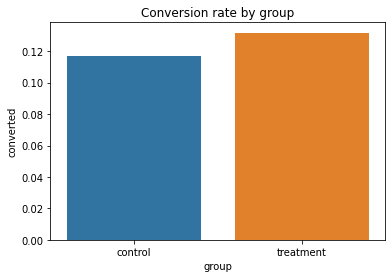

In [68]:
sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)
plt.title('Conversion rate by group')

**treatment group is getting higher converstion rate, is means that the new page is better,
but is this difference *statistically significant*?**

In [69]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -2.22
p-value: 0.027
ci 95% for control group: [0.108, 0.126]
ci 95% for treatment group: [0.122, 0.141]


- **our threshold of p-value is 0.5 and it's 0.027 so we can reject the null hypothesis and the new page is statistically significant.**
<br>
- The margin of error is a statistic expressing the amount of random sampling error in the results of a survey. The larger the margin of error, the less confidence one should have that a poll result would reflect the result of a census of the entire population, and we have around **0.02 margin error**. 